In [1]:
import os
import pickle
from win32gui import FindWindow, SetForegroundWindow, GetClientRect, ClientToScreen
import pyautogui
import cv2
import numpy as np
import tensorflow as tf
import tkinter as tk
from PIL import Image, ImageTk
from threading import Thread
from ctypes import windll
from math import floor, ceil
import win32api
import time

In [2]:
#------------------------------------------------------------------------------------------------------------------------------

In [3]:
checkpoint_path = "C:/Users/8holz/Dokumente/GitHub/K14/Training_Protocol/Model-Color-UNET-Terrosristhunt/weights/saved_model.pb"
checkpoint_dir = os.path.dirname(checkpoint_path)

WindowClassName0 = 'Rainbow Six'
WindowClassName1 = 'J4 - Jupyter Notebook - Google Chrome'
WindowClassName2 = 'r'

PredImage = None
ImageTesten = None

DATADIR5 = r"D:\K14\Dataset\Predicitions.pickle"

StopKey = True
MouseDown = False

In [8]:
Template = pickle.load(open(r"D:\K14\Dataset\Predicitions.pickle", "rb"))[40]

In [9]:
#------------------------------------------------------------------------------------------------------------------------------

In [10]:
def screenshot(window_title=None, lenx=512, leny=512):
	if window_title:
		hwnd = FindWindow(None, window_title)
		if hwnd:
			SetForegroundWindow(hwnd)
			x, y, x1, y1 = GetClientRect(hwnd)
			x, y = ClientToScreen(hwnd, (x, y))
			x1, y1 = ClientToScreen(hwnd, (x1 - x, y1 - y))
			# x,y,x1,y1 position and size
			x += int((x1-lenx)/2)
			x1 = lenx
			y += int((y1-leny)/2)
			y1 = leny
			im = pyautogui.screenshot(region=(x, y, x1, y1))
			gray = np.array(im)
			image = np.array(gray).reshape(-1, lenx, leny, 3)
			return image
		else:
			print('Window not found!')
	else:
		im = pyautogui.screenshot()
		gray = cv2.cvtColor(np.array(im))
		image = np.array(gray).reshape(-1, lenx, leny, 3)
		return image

In [11]:
def load_K14():
    #model = create_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    #model.summary()
    model = tf.keras.models.load_model(checkpoint_dir)
    #model.summary()

    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)
    return model

In [12]:
model = load_K14()

In [13]:
def xyz(image):
    im_preds = model.predict_on_batch(image)
    image = image.reshape(512, 512, 3)
    im_preds = tf.reshape(im_preds, [512, 512, 1]).numpy()
    #ImCompareGray(image, im_preds)
    return im_preds

In [14]:
def Coords(Pred, small):
	#cv2, Predicitons.pickle[2]=small
	Pred = (255 - cv2.inRange(np.array(Pred * 255, dtype = np.uint8), 0, 160)).astype(np.float32)
	small = np.array(small * 255, dtype = np.uint8).astype(np.float32)
	result = cv2.matchTemplate(Pred, small, cv2.TM_SQDIFF_NORMED)
	mn,_,mnLoc,_ = cv2.minMaxLoc(result)
	MPx,MPy = mnLoc
	#x and y may flipped
	return (MPx+2-256, MPy+2-256)
	#return (MPx, MPy)

In [15]:
def MouseControlV3(distx, disty, strength=1, Exceptions=[], MaxIterations=6):
    #32 directions, 512 distances, 1 Iteration = 0.015
    x = distx*strength
    y = disty*strength
    print(x,y)
    if x not in Exceptions or y not in Exceptions:
        if min(x,y)<=1:
            windll.user32.mouse_event(0x0001, int(x), int(y), 0, 0)
        else:
            if min(x,y)>MaxIterations:
                Iterations = 6
            else:
                Iterations=ceil(min(x,y))
            x1 = floor(x/(Iterations-1))
            y1 = floor(y/(Iterations-1))
            for i in range(Iterations-1):
                windll.user32.mouse_event(0x0001, x1, y1, 0, 0)
                time.sleep(0.005)
            windll.user32.mouse_event(0x0001, int(x)-(x1*Iterations-1), int(y)-(y1*Iterations-1), 0, 0)

In [16]:
"""
def Coords2(Pred, small):
	pred = Pred
	#cv2, Predicitons.pickle[2]=small
	result = cv2.matchTemplate(pred, small, cv2.TM_SQDIFF_NORMED)
	mn,_,mnLoc,_ = cv2.minMaxLoc(result)
	MPx,MPy = mnLoc
	trows,tcols = small.shape[:2]
	cv2.rectangle(pred, (MPx,MPy),(MPx+tcols,MPy+trows),(0,0,0),2)
	#x and y may flipped
	return pred
    """

'\ndef Coords2(Pred, small):\n\tpred = Pred\n\t#cv2, Predicitons.pickle[2]=small\n\tresult = cv2.matchTemplate(pred, small, cv2.TM_SQDIFF_NORMED)\n\tmn,_,mnLoc,_ = cv2.minMaxLoc(result)\n\tMPx,MPy = mnLoc\n\ttrows,tcols = small.shape[:2]\n\tcv2.rectangle(pred, (MPx,MPy),(MPx+tcols,MPy+trows),(0,0,0),2)\n\t#x and y may flipped\n\treturn pred\n    '

In [17]:
class myThread(Thread):
	def __init__(self):
		Thread.__init__(self)
		None
	def run(self):
		print("Photographer")
		# if Mouse is clicked provisional to final
		global StopKey, MouseDown
		while StopKey:
			MouseState = win32api.GetKeyState(0x01)
			if MouseState == -127 or MouseState == -128:  # Button state changed
				MouseDown = True
				state_left = MouseState
			else:
				MouseDown = False
			time.sleep(0.001)

In [18]:
class myThread1(Thread):
	def __init__(self):
		Thread.__init__(self)
		None
	def run(self):
		# saves the images in the global list
		root = tk.Tk()
		canvas = tk.Canvas(root, width = 512, height = 512)
		canvas.pack()
		def recursive():
			global ImageTesten, PredImage
			ImageTesten = ImageTk.PhotoImage(Image.fromarray((cv2.cvtColor(PredImage,cv2.COLOR_GRAY2RGB) * 255).astype(np.uint8)))
			#ImageTesten = tk.PhotoImage(file=DATADIR2+random.choice(os.listdir(DATADIR2)))
			canvas.create_image(0,0, anchor=tk.NW, image=ImageTesten)
			root.after(100, recursive)
		recursive()
		root.mainloop()

In [19]:
class MouseControlV4(Thread):
	def __init__(self):
		Thread.__init__(self)
		None
	def run(self):
	    #32 directions, 512 distances, 1 Iteration = 0.015
		global distx, disty, strength, Exceptions, MaxIterations
		Ldistx, Ldisty = distx, disty
		while StopKey:
			if Ldistx != distx or Ldisty != disty:
				t = time.time()
				Ldistx = distx
				Ldisty = disty
				Lstrength = strength
				LExceptions = Exceptions
				LMaxIterations = MaxIterations
				x = distx*strength
				y = disty*strength
				#print(x,y)
				if x not in Exceptions or y not in Exceptions:
					if min(x,y)<=1:
						windll.user32.mouse_event(0x0001, int(x), int(y), 0, 0)
					else:
						if min(x,y)>MaxIterations:
							Iterations = 6
						else:
							Iterations=ceil(min(x,y))
						x1 = floor(x/(Iterations-1))
						y1 = floor(y/(Iterations-1))
						for i in range(Iterations-1):
							windll.user32.mouse_event(0x0001, x1, y1, 0, 0)
							time.sleep(0.005)
						windll.user32.mouse_event(0x0001, int(x)-(x1*Iterations-1), int(y)-(y1*Iterations-1), 0, 0)
				print(time.time()-t)
			time.sleep(0.05)

In [20]:
#------------------------------------------------------------------------------------------------------------------------------

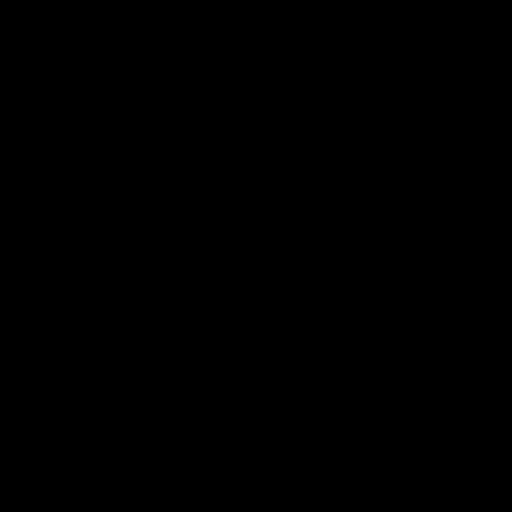

In [21]:
PredImage=xyz(screenshot(WindowClassName1))
#print(PredImage)
Image.fromarray((cv2.cvtColor(PredImage,cv2.COLOR_GRAY2RGB) * 255).astype(np.uint8))

In [22]:
#------------------------------------------------------------------------------------------------------------------------------

In [23]:
distx, disty = 0, 0
strength = 1
Exceptions = [-76.2, 33.3, -35.699999999999996, 77.0, -88.5, -127.0, -97.5, 32.5, -21.5, -68.0, -254]
MaxIterations = 3

In [24]:
inst0 = myThread()
inst1 = MouseControlV4()
inst0.start()
inst1.start()

Photographer


In [25]:
time.sleep(10)

In [26]:
while True:
    if MouseDown:
        #t = time.time()
        PredImage=Coords(xyz(screenshot(WindowClassName0)), Template)
        distx, disty = PredImage[0], PredImage[1]
        #print("-----------------------------", time.time()-t)

0.0
0.21393990516662598
0.26628589630126953
0.26331305503845215
0.0
0.09275174140930176
0.0
0.014960289001464844
0.07032084465026855
0.08277702331542969
0.0
0.0
0.2186441421508789
0.0009982585906982422
0.0
0.0
0.014959335327148438
0.000995635986328125
0.000997781753540039
0.0009975433349609375
0.12150764465332031
0.14198899269104004
0.0
0.0
0.0
0.0009982585906982422
0.0
0.0009968280792236328
0.0
0.0
0.0
0.0
0.0009975433349609375
0.0009975433349609375
0.0009980201721191406
0.0
0.0
0.14583301544189453
0.0
0.0
0.0009963512420654297
0.14513182640075684
0.0
0.0009982585906982422
0.0009975433349609375
0.0009970664978027344
0.13663434982299805
0.1406245231628418
0.0009975433349609375
0.0
0.0
0.0
0.13997507095336914
0.0009987354278564453
0.000997304916381836
0.0009982585906982422
0.0009996891021728516
0.12865972518920898
0.14412617683410645
0.1392817497253418
0.12666010856628418
0.1466081142425537
0.12366914749145508
0.13563776016235352
0.13763046264648438
0.0
0.0009970664978027344
0.000998258

0.0009987354278564453
0.0
0.0009968280792236328
0.1346433162689209
0.000997304916381836
0.0009982585906982422
0.0
0.0009996891021728516
0.000997781753540039
0.0009968280792236328
0.0009992122650146484
0.000997781753540039
0.0009987354278564453
0.000995635986328125
0.0
0.0
0.1466066837310791
0.0
0.0
0.0009980201721191406
0.0009961128234863281
0.13177704811096191
0.0
0.0
0.0009968280792236328
0.13913750648498535
0.0
0.0009965896606445312
0.0
0.0
0.0
0.13863086700439453
0.0
0.0
0.0009980201721191406
0.14413118362426758
0.0
0.0
0.0009975433349609375
0.0
0.000997781753540039
0.14162230491638184
0.0
0.0009987354278564453
0.0009984970092773438
0.0009989738464355469
0.0
0.1466071605682373
0.015956878662109375
0.0


KeyboardInterrupt: 